# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

import matplotlib as plt
%matplotlib inline

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpive8wwq9
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpive8wwq9/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpive8wwq9/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,3 hours and 37 minutes
H2O cluster name:,H2O_from_python_phall_08mo8c
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Import data

In [2]:
train = h2o.import_file('../../03_regression/data/train.csv')
test = h2o.import_file('../../03_regression/data/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['OverallQual', 'KitchenAbvGr', 'YrSold', 'LotArea', 'PoolArea', 'BsmtHalfBath', 'TotRmsAbvGrd', 'OverallCond', 'YearBuilt', 'ScreenPorch', 'MoSold', 'OpenPorchSF', 'BsmtFinSF2', '1stFlrSF', 'TotalBsmtSF', 'YearRemodAdd', 'GrLivArea', 'EnclosedPorch', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'LotFrontage', 'MasVnrArea', 'BedroomAbvGr', '3SsnPorch', '2ndFlrSF', 'LowQualFinSF', 'MSSubClass', 'GarageCars', 'MiscVal', 'BsmtFullBath', 'FullBath', 'HalfBath', 'WoodDeckSF', 'Fireplaces']

Categorical = ['ExterCond', 'RoofStyle', 'BsmtCond', 'LotShape', 'Foundation', 'Heating', 'KitchenQual', 'BsmtFinType2', 'HouseStyle', 'Fence', 'MSZoning', 'Street', 'LandContour', 'HeatingQC', 'GarageType', 'Exterior2nd', 'FireplaceQu', 'CentralAir', 'SaleCondition', 'RoofMatl', 'GarageQual', 'LandSlope', 'BsmtFinType1', 'SaleType', 'BsmtExposure', 'Exterior1st', 'PavedDrive', 'Functional', 'MasVnrType', 'GarageCond', 'MiscFeature', 'Alley', 'PoolQC', 'BsmtQual', 'Neighborhood', 'Co

## Split into to train and validation (before doing data prep!!!)

In [5]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [6]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [7]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [8]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: ExterCond (1/43) ...
Encoding: RoofStyle (2/43) ...
Encoding: BsmtCond (3/43) ...
Encoding: LotShape (4/43) ...
Encoding: Foundation (5/43) ...
Encoding: Heating (6/43) ...
Encoding: KitchenQual (7/43) ...
Encoding: BsmtFinType2 (8/43) ...
Encoding: HouseStyle (9/43) ...
Encoding: Fence (10/43) ...
Encoding: MSZoning (11/43) ...
Encoding: Street (12/43) ...
Encoding: LandContour (13/43) ...
Encoding: HeatingQC (14/43) ...
Encoding: GarageType (15/43) ...
Encoding: Exterior2nd (16/43) ...
Encoding: FireplaceQu (17/43) ...
Encoding: CentralAir (18/43) ...
Encoding: SaleCondition (19/43) ...
Encoding: RoofMatl (20/43) ...
Encoding: GarageQual (21/43) ...
Encoding: LandSlope (22/43) ...
Encoding: BsmtFinType1 (23/43) ...
Encoding: SaleType (24/43) ...
Encoding: BsmtExposure (25/43) ...
Encoding: Exterior1st (26/43) ...
Encoding: PavedDrive (27/43) ...
Encoding: Functional (28/43) ...
Encoding: MasVnrType (29/43) ...
Encoding: GarageCond (30/43) ...
Encoding: MiscFeature (31/43) .

#### One-hot encode categorical variables

In [9]:
# one-hot encode training frame
train_cats_df = train[cats].as_data_frame()
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = valid[cats].as_data_frame()
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = test[cats].as_data_frame()
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = test.cbind(test_one_hot) 

(1001, 216)
(459, 216)
True
(1001, 211)
(459, 211)
True
(1001, 211)
(459, 211)
(1459, 211)
True


#### Redefine numerics and explore

In [10]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['OverallQual', 'KitchenAbvGr', 'SaleCondition_Tencode', 'FireplaceQu_Tencode', 'Condition1_Artery', 'YrSold', 'Utilities_Tencode', 'BsmtExposure_Tencode', 'PavedDrive_N', 'LotShape_Tencode', 'GarageType_Detchd', 'Exterior1st_BrkFace', 'GarageFinish_Unf', 'Exterior2nd_AsbShng', 'Exterior2nd_Stucco', 'BldgType_Duplex', 'Neighborhood_BrDale', 'ExterQual_TA', 'LotShape_IR2', 'Exterior2nd_Stone', 'RoofMatl_Tencode', 'Street_Tencode', 'LandContour_Low', 'Neighborhood_NridgHt', 'TotalBsmtSF', 'RoofStyle_Hip', 'BsmtFinType1_Tencode', 'HouseStyle_1Story', 'GarageCond_Po', 'BldgType_2fmCon', 'YearRemodAdd', 'GrLivArea', 'EnclosedPorch', 'Foundation_PConc', 'Neighborhood_NPkVill', 'RoofStyle_Flat', 'HeatingQC_TA', 'Neighborhood_Blmngtn', 'FireplaceQu_Gd', 'BsmtFinType2_Tencode', 'LotShape_Reg', 'Exterior1st_HdBoard', 'HeatingQC_Fa', 'Alley_Pave', 'BsmtFinType1_BLQ', 'LotFrontage', 'Heating_GasA', 'GarageCond_TA', 'Neighborhood_Somerst', 'HouseStyle_SFoyer', 'Neighborhood_ClearCr', 'Fun

In [11]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:290




,OverallQual,KitchenAbvGr,SaleCondition_Tencode,FireplaceQu_Tencode,Condition1_Artery,YrSold,Utilities_Tencode,BsmtExposure_Tencode,PavedDrive_N,LotShape_Tencode,GarageType_Detchd,Exterior1st_BrkFace,GarageFinish_Unf,Exterior2nd_AsbShng,Exterior2nd_Stucco,BldgType_Duplex,Neighborhood_BrDale,ExterQual_TA,LotShape_IR2,Exterior2nd_Stone,RoofMatl_Tencode,Street_Tencode,LandContour_Low,Neighborhood_NridgHt,TotalBsmtSF,RoofStyle_Hip,BsmtFinType1_Tencode,HouseStyle_1Story,GarageCond_Po,BldgType_2fmCon,YearRemodAdd,GrLivArea,EnclosedPorch,Foundation_PConc,Neighborhood_NPkVill,RoofStyle_Flat,HeatingQC_TA,Neighborhood_Blmngtn,FireplaceQu_Gd,BsmtFinType2_Tencode,LotShape_Reg,Exterior1st_HdBoard,HeatingQC_Fa,Alley_Pave,BsmtFinType1_BLQ,LotFrontage,Heating_GasA,GarageCond_TA,Neighborhood_Somerst,HouseStyle_SFoyer,Neighborhood_ClearCr,Functional_Tencode,Alley_Tencode,Functional_Typ,GarageQual_Gd,GarageCars,BldgType_Twnhs,LotShape_IR1,HeatingQC_Gd,KitchenQual_Gd,ExterCond_TA,Electrical_Tencode,Foundation_Stone,BsmtFinType2_GLQ,Electrical_FuseP,Heating_Grav,LotConfig_Corner,Neighborhood_CollgCr,MiscFeature_Othr,Electrical_FuseA,FullBath,GarageFinish_Fin,Fireplaces,Neighborhood_Mitchel,Exterior1st_AsbShng,LandSlope_Mod,SaleType_ConLw,FireplaceQu_Po,BsmtQual_Tencode,LotArea,Exterior2nd_BrkFace,BsmtFinType2_ALQ,RoofMatl_CompShg,BsmtHalfBath,HouseStyle_Tencode,Neighborhood_NoRidge,GarageCond_Tencode,Foundation_BrkTil,Exterior2nd_Tencode,Exterior1st_Stucco,MiscVal,BsmtFinSF2,LotConfig_FR2,Fence_Tencode,KitchenQual_Ex,Neighborhood_Tencode,YearBuilt,LandSlope_Sev,Heating_Tencode,LandContour_HLS,Neighborhood_OldTown,SaleType_Tencode,Exterior2nd_VinylSd,SaleType_ConLD,GarageType_Tencode,SaleType_ConLI,Heating_GasW,LandContour_Tencode,Neighborhood_Veenker,Foundation_Tencode,LandSlope_Tencode,Neighborhood_Edwards,BsmtQual_Ex,BedroomAbvGr,Electrical_SBrkr,BsmtFinType2_BLQ,PavedDrive_Y,PoolQC_Tencode,SaleCondition_Family,BsmtFinType1_ALQ,BsmtQual_Fa,SaleType_WD,LandContour_Bnk,3SsnPorch,LandContour_Lvl,Neighborhood_SWISU,HeatingQC_Tencode,PavedDrive_Tencode,HalfBath,Fence_GdPrv,HeatingQC_Ex,RoofMatl_Tar&Grv,LotConfig_CulDSac,HouseStyle_1.5Unf,BsmtFullBath,GarageQual_Fa,ExterCond_Gd,BsmtQual_TA,Functional_Maj2,SaleCondition_Alloca,Condition1_PosA,GarageCond_Gd,GarageQual_TA,FireplaceQu_Fa,KitchenQual_Tencode,Condition2_Tencode,BsmtFinType1_Rec,ExterCond_Tencode,GarageFinish_Tencode,RoofStyle_Gambrel,Exterior1st_CemntBd,MSZoning_C (all),Condition1_PosN,Exterior2nd_MetalSd,RoofStyle_Gable,GarageType_BuiltIn,Electrical_FuseF,Condition1_RRAe,TotRmsAbvGrd,LowQualFinSF,SaleType_New,RoofStyle_Shed,Functional_Maj1,MoSold,Neighborhood_NWAmes,MasVnrType_BrkCmn,Exterior2nd_CmentBd,1stFlrSF,GarageCond_Fa,BsmtFinType2_Rec,GarageType_Attchd,MiscFeature_Shed,BsmtExposure_Av,SaleCondition_Normal,Condition1_Norm,BsmtFinType2_LwQ,GarageQual_Po,Neighborhood_NAmes,GarageArea,Functional_Min1,LotConfig_Tencode,OpenPorchSF,Condition1_Feedr,ExterQual_Ex,BsmtUnfSF,GarageType_CarPort,LandSlope_Gtl,Functional_Mod,FireplaceQu_Ex,MSZoning_RM,RoofStyle_Tencode,2ndFlrSF,Exterior2nd_Wd Sdng,BsmtCond_Gd,BsmtCond_Po,MiscFeature_Tencode,Neighborhood_StoneBr,MasVnrType_None,Neighborhood_Sawyer,BldgType_TwnhsE,ExterQual_Gd,KitchenQual_Fa,Foundation_CBlock,BsmtCond_Tencode,Neighborhood_Crawfor,GarageType_Basment,Condition2_Artery,Fence_GdWo,MSSubClass,BsmtFinType1_LwQ,SaleCondition_Partial,Exterior1st_VinylSd,CentralAir_Y,Condition1_Tencode,Street_Grvl,PavedDrive_P,GarageCond_Ex,BsmtFinType2_Unf,HouseStyle_2.5Unf,Neighborhood_Gilbert,BsmtFinSF1,PoolArea,CentralAir_Tencode,SaleType_COD,GarageFinish_RFn,FireplaceQu_TA,GarageQual_Tencode,OverallCond,BldgType_1Fam,SaleCondition_Abnorml,ScreenPorch,Exterior1st_BrkComm,Exterior2nd_Brk Cmn,SaleType_Oth,BsmtExposure_Gd,GarageYrBlt,Alley_Grvl,BldgType_Tencode,ExterQual_Tencode,KitchenQual_TA,CentralAir_N,Neighborhood_SawyerW,MSZoning_Tencode,BsmtFinType1_Unf,Condition1_RRAn,Neighborhood_IDOTRR,Condition2_Norm,MiscFeature_Gar2,SaleType_CWD,Neighborhood_

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:290




,OverallQual,KitchenAbvGr,SaleCondition_Tencode,FireplaceQu_Tencode,Condition1_Artery,YrSold,Utilities_Tencode,BsmtExposure_Tencode,PavedDrive_N,LotShape_Tencode,GarageType_Detchd,Exterior1st_BrkFace,GarageFinish_Unf,Exterior2nd_AsbShng,Exterior2nd_Stucco,BldgType_Duplex,Neighborhood_BrDale,ExterQual_TA,LotShape_IR2,Exterior2nd_Stone,RoofMatl_Tencode,Street_Tencode,LandContour_Low,Neighborhood_NridgHt,TotalBsmtSF,RoofStyle_Hip,BsmtFinType1_Tencode,HouseStyle_1Story,GarageCond_Po,BldgType_2fmCon,YearRemodAdd,GrLivArea,EnclosedPorch,Foundation_PConc,Neighborhood_NPkVill,RoofStyle_Flat,HeatingQC_TA,Neighborhood_Blmngtn,FireplaceQu_Gd,BsmtFinType2_Tencode,LotShape_Reg,Exterior1st_HdBoard,HeatingQC_Fa,Alley_Pave,BsmtFinType1_BLQ,LotFrontage,Heating_GasA,GarageCond_TA,Neighborhood_Somerst,HouseStyle_SFoyer,Neighborhood_ClearCr,Functional_Tencode,Alley_Tencode,Functional_Typ,GarageQual_Gd,GarageCars,BldgType_Twnhs,LotShape_IR1,HeatingQC_Gd,KitchenQual_Gd,ExterCond_TA,Electrical_Tencode,Foundation_Stone,BsmtFinType2_GLQ,Electrical_FuseP,Heating_Grav,LotConfig_Corner,Neighborhood_CollgCr,MiscFeature_Othr,Electrical_FuseA,FullBath,GarageFinish_Fin,Fireplaces,Neighborhood_Mitchel,Exterior1st_AsbShng,LandSlope_Mod,SaleType_ConLw,FireplaceQu_Po,BsmtQual_Tencode,LotArea,Exterior2nd_BrkFace,BsmtFinType2_ALQ,RoofMatl_CompShg,BsmtHalfBath,HouseStyle_Tencode,Neighborhood_NoRidge,GarageCond_Tencode,Foundation_BrkTil,Exterior2nd_Tencode,Exterior1st_Stucco,MiscVal,BsmtFinSF2,LotConfig_FR2,Fence_Tencode,KitchenQual_Ex,Neighborhood_Tencode,YearBuilt,LandSlope_Sev,Heating_Tencode,LandContour_HLS,Neighborhood_OldTown,SaleType_Tencode,Exterior2nd_VinylSd,SaleType_ConLD,GarageType_Tencode,SaleType_ConLI,Heating_GasW,LandContour_Tencode,Neighborhood_Veenker,Foundation_Tencode,LandSlope_Tencode,Neighborhood_Edwards,BsmtQual_Ex,BedroomAbvGr,Electrical_SBrkr,BsmtFinType2_BLQ,PavedDrive_Y,PoolQC_Tencode,SaleCondition_Family,BsmtFinType1_ALQ,BsmtQual_Fa,SaleType_WD,LandContour_Bnk,3SsnPorch,LandContour_Lvl,Neighborhood_SWISU,HeatingQC_Tencode,PavedDrive_Tencode,HalfBath,Fence_GdPrv,HeatingQC_Ex,RoofMatl_Tar&Grv,LotConfig_CulDSac,HouseStyle_1.5Unf,BsmtFullBath,GarageQual_Fa,ExterCond_Gd,BsmtQual_TA,Functional_Maj2,SaleCondition_Alloca,Condition1_PosA,GarageCond_Gd,GarageQual_TA,FireplaceQu_Fa,KitchenQual_Tencode,Condition2_Tencode,BsmtFinType1_Rec,ExterCond_Tencode,GarageFinish_Tencode,RoofStyle_Gambrel,Exterior1st_CemntBd,MSZoning_C (all),Condition1_PosN,Exterior2nd_MetalSd,RoofStyle_Gable,GarageType_BuiltIn,Electrical_FuseF,Condition1_RRAe,TotRmsAbvGrd,LowQualFinSF,SaleType_New,RoofStyle_Shed,Functional_Maj1,MoSold,Neighborhood_NWAmes,MasVnrType_BrkCmn,Exterior2nd_CmentBd,1stFlrSF,GarageCond_Fa,BsmtFinType2_Rec,GarageType_Attchd,MiscFeature_Shed,BsmtExposure_Av,SaleCondition_Normal,Condition1_Norm,BsmtFinType2_LwQ,GarageQual_Po,Neighborhood_NAmes,GarageArea,Functional_Min1,LotConfig_Tencode,OpenPorchSF,Condition1_Feedr,ExterQual_Ex,BsmtUnfSF,GarageType_CarPort,LandSlope_Gtl,Functional_Mod,FireplaceQu_Ex,MSZoning_RM,RoofStyle_Tencode,2ndFlrSF,Exterior2nd_Wd Sdng,BsmtCond_Gd,BsmtCond_Po,MiscFeature_Tencode,Neighborhood_StoneBr,MasVnrType_None,Neighborhood_Sawyer,BldgType_TwnhsE,ExterQual_Gd,KitchenQual_Fa,Foundation_CBlock,BsmtCond_Tencode,Neighborhood_Crawfor,GarageType_Basment,Condition2_Artery,Fence_GdWo,MSSubClass,BsmtFinType1_LwQ,SaleCondition_Partial,Exterior1st_VinylSd,CentralAir_Y,Condition1_Tencode,Street_Grvl,PavedDrive_P,GarageCond_Ex,BsmtFinType2_Unf,HouseStyle_2.5Unf,Neighborhood_Gilbert,BsmtFinSF1,PoolArea,CentralAir_Tencode,SaleType_COD,GarageFinish_RFn,FireplaceQu_TA,GarageQual_Tencode,OverallCond,BldgType_1Fam,SaleCondition_Abnorml,ScreenPorch,Exterior1st_BrkComm,Exterior2nd_Brk Cmn,SaleType_Oth,BsmtExposure_Gd,GarageYrBlt,Alley_Grvl,BldgType_Tencode,ExterQual_Tencode,KitchenQual_TA,CentralAir_N,Neighborhood_SawyerW,MSZoning_Tencode,BsmtFinType1_Unf,Condition1_RRAn,Neighborhood_IDOTRR,Condition2_Norm,MiscFeature_Gar2,SaleType_CWD,Neighborhood_

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:290




,OverallQual,KitchenAbvGr,SaleCondition_Tencode,FireplaceQu_Tencode,Condition1_Artery,YrSold,Utilities_Tencode,BsmtExposure_Tencode,PavedDrive_N,LotShape_Tencode,GarageType_Detchd,Exterior1st_BrkFace,GarageFinish_Unf,Exterior2nd_AsbShng,Exterior2nd_Stucco,BldgType_Duplex,Neighborhood_BrDale,ExterQual_TA,LotShape_IR2,Exterior2nd_Stone,RoofMatl_Tencode,Street_Tencode,LandContour_Low,Neighborhood_NridgHt,TotalBsmtSF,RoofStyle_Hip,BsmtFinType1_Tencode,HouseStyle_1Story,GarageCond_Po,BldgType_2fmCon,YearRemodAdd,GrLivArea,EnclosedPorch,Foundation_PConc,Neighborhood_NPkVill,RoofStyle_Flat,HeatingQC_TA,Neighborhood_Blmngtn,FireplaceQu_Gd,BsmtFinType2_Tencode,LotShape_Reg,Exterior1st_HdBoard,HeatingQC_Fa,Alley_Pave,BsmtFinType1_BLQ,LotFrontage,Heating_GasA,GarageCond_TA,Neighborhood_Somerst,HouseStyle_SFoyer,Neighborhood_ClearCr,Functional_Tencode,Alley_Tencode,Functional_Typ,GarageQual_Gd,GarageCars,BldgType_Twnhs,LotShape_IR1,HeatingQC_Gd,KitchenQual_Gd,ExterCond_TA,Electrical_Tencode,Foundation_Stone,BsmtFinType2_GLQ,Electrical_FuseP,Heating_Grav,LotConfig_Corner,Neighborhood_CollgCr,MiscFeature_Othr,Electrical_FuseA,FullBath,GarageFinish_Fin,Fireplaces,Neighborhood_Mitchel,Exterior1st_AsbShng,LandSlope_Mod,SaleType_ConLw,FireplaceQu_Po,BsmtQual_Tencode,LotArea,Exterior2nd_BrkFace,BsmtFinType2_ALQ,RoofMatl_CompShg,BsmtHalfBath,HouseStyle_Tencode,Neighborhood_NoRidge,GarageCond_Tencode,Foundation_BrkTil,Exterior2nd_Tencode,Exterior1st_Stucco,MiscVal,BsmtFinSF2,LotConfig_FR2,Fence_Tencode,KitchenQual_Ex,Neighborhood_Tencode,YearBuilt,LandSlope_Sev,Heating_Tencode,LandContour_HLS,Neighborhood_OldTown,SaleType_Tencode,Exterior2nd_VinylSd,SaleType_ConLD,GarageType_Tencode,SaleType_ConLI,Heating_GasW,LandContour_Tencode,Neighborhood_Veenker,Foundation_Tencode,LandSlope_Tencode,Neighborhood_Edwards,BsmtQual_Ex,BedroomAbvGr,Electrical_SBrkr,BsmtFinType2_BLQ,PavedDrive_Y,PoolQC_Tencode,SaleCondition_Family,BsmtFinType1_ALQ,BsmtQual_Fa,SaleType_WD,LandContour_Bnk,3SsnPorch,LandContour_Lvl,Neighborhood_SWISU,HeatingQC_Tencode,PavedDrive_Tencode,HalfBath,Fence_GdPrv,HeatingQC_Ex,RoofMatl_Tar&Grv,LotConfig_CulDSac,HouseStyle_1.5Unf,BsmtFullBath,GarageQual_Fa,ExterCond_Gd,BsmtQual_TA,Functional_Maj2,SaleCondition_Alloca,Condition1_PosA,GarageCond_Gd,GarageQual_TA,FireplaceQu_Fa,KitchenQual_Tencode,Condition2_Tencode,BsmtFinType1_Rec,ExterCond_Tencode,GarageFinish_Tencode,RoofStyle_Gambrel,Exterior1st_CemntBd,MSZoning_C (all),Condition1_PosN,Exterior2nd_MetalSd,RoofStyle_Gable,GarageType_BuiltIn,Electrical_FuseF,Condition1_RRAe,TotRmsAbvGrd,LowQualFinSF,SaleType_New,RoofStyle_Shed,Functional_Maj1,MoSold,Neighborhood_NWAmes,MasVnrType_BrkCmn,Exterior2nd_CmentBd,1stFlrSF,GarageCond_Fa,BsmtFinType2_Rec,GarageType_Attchd,MiscFeature_Shed,BsmtExposure_Av,SaleCondition_Normal,Condition1_Norm,BsmtFinType2_LwQ,GarageQual_Po,Neighborhood_NAmes,GarageArea,Functional_Min1,LotConfig_Tencode,OpenPorchSF,Condition1_Feedr,ExterQual_Ex,BsmtUnfSF,GarageType_CarPort,LandSlope_Gtl,Functional_Mod,FireplaceQu_Ex,MSZoning_RM,RoofStyle_Tencode,2ndFlrSF,Exterior2nd_Wd Sdng,BsmtCond_Gd,BsmtCond_Po,MiscFeature_Tencode,Neighborhood_StoneBr,MasVnrType_None,Neighborhood_Sawyer,BldgType_TwnhsE,ExterQual_Gd,KitchenQual_Fa,Foundation_CBlock,BsmtCond_Tencode,Neighborhood_Crawfor,GarageType_Basment,Condition2_Artery,Fence_GdWo,MSSubClass,BsmtFinType1_LwQ,SaleCondition_Partial,Exterior1st_VinylSd,CentralAir_Y,Condition1_Tencode,Street_Grvl,PavedDrive_P,GarageCond_Ex,BsmtFinType2_Unf,HouseStyle_2.5Unf,Neighborhood_Gilbert,BsmtFinSF1,PoolArea,CentralAir_Tencode,SaleType_COD,GarageFinish_RFn,FireplaceQu_TA,GarageQual_Tencode,OverallCond,BldgType_1Fam,SaleCondition_Abnorml,ScreenPorch,Exterior1st_BrkComm,Exterior2nd_Brk Cmn,SaleType_Oth,BsmtExposure_Gd,GarageYrBlt,Alley_Grvl,BldgType_Tencode,ExterQual_Tencode,KitchenQual_TA,CentralAir_N,Neighborhood_SawyerW,MSZoning_Tencode,BsmtFinType1_Unf,Condition1_RRAn,Neighborhood_IDOTRR,Condition2_Norm,MiscFeature_Gar2,SaleType_CWD,Neighborhood_

In [12]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'CollgCr': 190019.77971813726, 'Gilbert': 191808.0596949891, 'SWISU': 156269.02450980392, 'Edwards': 126241.13989441929, 'Blmngtn': 210845.6545098039, 'NPkVill': 147641.52450980392, 'Timber': 260109.74673202613, 'NridgHt': 284073.1545098039, 'SawyerW': 189097.7776348039, 'BrDale': 116064.02450980392, 'Crawfor': 216008.84593837534, 'BrkSide': 129965.77450980392, 'Somerst': 227656.9671023965, 'Sawyer': 143162.40700980392, 'MeadowV': 113131.52450980392, 'ClearCr': 207949.02450980392, 'NoRidge': 273948.2552790347, 'Veenker': 243734.02450980392, 'IDOTRR': 112866.71681749621, 'StoneBr': 288359.0245098039, 'NAmes': 152080.32258672698, 'OldTown': 139863.03613771088, 'Mitchel': 169316.52450980392, 'NWAmes': 184610.14950980392}


## Create combination features

In [13]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [14]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: OverallQual (1/290) ...
Combining: KitchenAbvGr (2/290) ...
Combining: SaleCondition_Tencode (3/290) ...
Combining: FireplaceQu_Tencode (4/290) ...
Combining: Condition1_Artery (5/290) ...
Combining: YrSold (6/290) ...
Combining: Utilities_Tencode (7/290) ...
Combining: BsmtExposure_Tencode (8/290) ...
Combining: PavedDrive_N (9/290) ...
Combining: LotShape_Tencode (10/290) ...
Combining: GarageType_Detchd (11/290) ...
Combining: Exterior1st_BrkFace (12/290) ...
Combining: GarageFinish_Unf (13/290) ...
Combining: Exterior2nd_AsbShng (14/290) ...
Combining: Exterior2nd_Stucco (15/290) ...
Combining: BldgType_Duplex (16/290) ...
Combining: Neighborhood_BrDale (17/290) ...
Combining: ExterQual_TA (18/290) ...
Combining: LotShape_IR2 (19/290) ...
Combining: Exterior2nd_Stone (20/290) ...
Combining: RoofMatl_Tencode (21/290) ...
Combining: Street_Tencode (22/290) ...
Combining: LandContour_Low (23/290) ...
Combining: Neighborhood_NridgHt (24/290) ...
Combining: TotalBsmtSF (25/29

#### Redefine numerics and explore

In [15]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['Exterior1st_BrkFace|GarageCond_TA', 'HouseStyle_SLvl|Fence_MnPrv', 'BldgType_Duplex|Alley_Tencode', 'RoofMatl_CompShg|ScreenPorch', 'FireplaceQu_TA|SaleType_Oth', 'GarageType_CarPort|BsmtCond_Po', 'SaleCondition_Tencode|BldgType_2fmCon', 'Foundation_BrkTil|Condition2_Tencode', 'GarageCond_Gd|MiscFeature_Tencode', 'Foundation_Stone|Neighborhood_Edwards', 'BsmtFinType1_ALQ|KitchenQual_Tencode', 'Exterior1st_Tencode|Neighborhood_MeadowV', 'Electrical_FuseA|SaleCondition_Partial', 'GarageQual_Gd|BsmtCond_Tencode', 'HouseStyle_SFoyer|Heating_GasW', 'LotShape_Reg|MasVnrType_Tencode', 'Condition1_Norm|SaleCondition_Abnorml', 'Neighborhood_OldTown', 'Heating_GasA|Neighborhood_Crawfor', 'Fence_Tencode|LandSlope_Tencode', 'RoofMatl_CompShg|HouseStyle_1.5Fin', 'ExterCond_TA|Exterior1st_BrkComm', '1stFlrSF|Neighborhood_Crawfor', 'MiscVal|TotRmsAbvGrd', 'MiscFeature_Othr|GarageYrBlt', 'CentralAir_N|MasVnrArea', 'BsmtFinType1_Tencode|SaleType_CWD', 'MiscVal|Condition1_PosN', 'LandSlope_S

In [16]:
# check number of created variables is correct
# 1 id column, 290)) combined variables
print(train.shape == (1001, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(train.shape)
print(test.shape == (1459, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(test.shape)

True
(1001, 42240)
True
(1459, 42240)


In [17]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

GarageType_Detchd,BsmtUnfSF,GarageType_Detchd|BsmtUnfSF
1,0,0


GarageType_Detchd,BsmtUnfSF,GarageType_Detchd|BsmtUnfSF
1,459,459



0.0
459.0


## Train models

In [18]:
h2o.show_progress()                                          # turn on progress bars

SalePrice
12.2477
12.109
12.3172


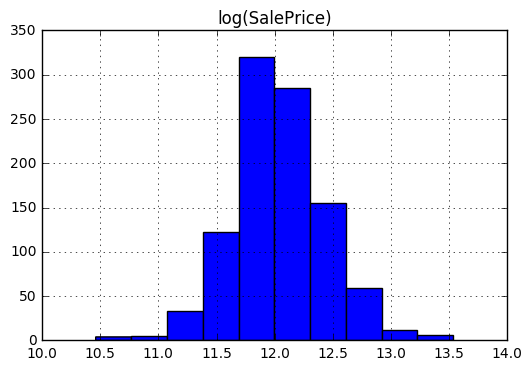

In [19]:
# Check log transform - looks good
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [20]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 42240)
(230, 42240)
(497, 42240)
(229, 42240)


#### Define model with grid search function

In [21]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


#### Function to generate submission file

In [22]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple function to average predictions

In [23]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### GLM model on encoded, combined numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_297_sid_b0f6_model_python_1527178741925_1_model_0   
1    [0.25]  Grid_GLM_py_297_sid_b0f6_model_python_1527178741925_1_model_1   
2     [0.5]  Grid_GLM_py_297_sid_b0f6_model_python_1527178741925_1_model_2   
3    [0.99]  Grid_GLM_py_297_sid_b0f6_model_python_1527178741925_1_model_3   

    residual_deviance  
0   3.405457702226766  
1  3.7310684358150157  
2  3.8448209999198233  
3  3.9680834547561457  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_297_sid_b0f6_model_python_1527178741925_1_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.005613386003704139
RMSE: 0.07492253335081603
MAE: 0.05825898630935005
RMSLE: 0.005798560012401194
R^2: 0.9641606895652494
Mean Residual Deviance: 0.005613386003704139
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-05-24 12:41:29,0.000 sec,1,.33E2,1,0.1566265,0.1507337
,2018-05-24 12:41:31,1.964 sec,2,.32E2,31,0.1538745,0.1481834
,2018-05-24 12:41:32,2.964 sec,3,.3E2,38,0.1488314,0.1435179
,2018-05-24 12:41:33,3.525 sec,4,.29E2,61,0.1430469,0.1382364
,2018-05-24 12:41:33,4.140 sec,5,.27E2,97,0.1361903,0.1321030
---,---,---,---,---,---,---,---
,2018-05-24 12:42:47,1 min 17.913 sec,84,.7E0,1405,0.0053438,0.0148147
,2018-05-24 12:42:48,1 min 19.138 sec,85,.66E0,1416,0.0050863,0.0148227
,2018-05-24 12:42:49,1 min 19.759 sec,86,.63E0,1461,0.0048310,0.0148520
,2018-05-24 12:42:50,1 min 20.391 sec,87,.61E0,1495,0.0045824,0.0149025



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0779
12.2061,12.1796
11.6784,11.6258
11.914,11.8076
12.6758,12.458
12.861,12.7095
12.1035,11.974
11.2898,11.4508
11.7714,11.6794
11.5843,11.601



glm prediction progress: |████████████████████████████████████████████████| 100%


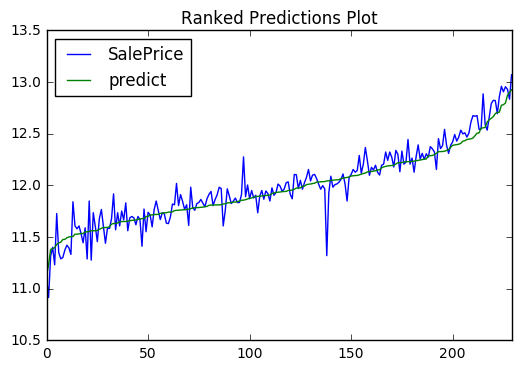

In [24]:
glm_0 = glm_grid(encoded_combined_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm_0) # Valid RMSE: ~0.1217,  0.13886 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_299_sid_b0f6_model_python_1527178741925_2_model_1   
1     [0.5]  Grid_GLM_py_299_sid_b0f6_model_python_1527178741925_2_model_2   
2    [0.99]  Grid_GLM_py_299_sid_b0f6_model_python_1527178741925_2_model_3   
3    [0.01]  Grid_GLM_py_299_sid_b0f6_model_python_1527178741925_2_model_0   

    residual_deviance  
0  3.1810866656007803  
1   3.223651696951385  
2   3.224159264892518  
3  3.2717453678471253  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_299_sid_b0f6_model_python_1527178741925_2_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.007094793397779883
RMSE: 0.08423059656549918
MAE: 0.06417733206371987
RMSLE: 0.00650329685007792
R^2: 0.9535567733748623
Mean Residual Deviance: 0.007094793397779883
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-05-24 12:49:01,0.000 sec,1,.13E1,1,0.1527627,0.1887304
,2018-05-24 12:49:01,0.519 sec,2,.12E1,4,0.1465437,0.1812044
,2018-05-24 12:49:02,1.042 sec,3,.12E1,10,0.1382035,0.1706804
,2018-05-24 12:49:02,1.548 sec,4,.11E1,12,0.1298958,0.1600478
,2018-05-24 12:49:03,2.029 sec,5,.11E1,14,0.1221530,0.1500932
---,---,---,---,---,---,---,---
,2018-05-24 12:49:53,52.579 sec,78,.36E-1,266,0.0061875,0.0139182
,2018-05-24 12:49:54,53.123 sec,79,.34E-1,280,0.0058955,0.0140077
,2018-05-24 12:49:54,53.661 sec,80,.32E-1,284,0.0056235,0.0140578
,2018-05-24 12:49:55,54.362 sec,81,.31E-1,289,0.0053548,0.0141352



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.7186
11.9117,11.9251
11.9767,11.8588
11.8451,11.7476
11.1346,11.2238
11.8845,11.8186
11.9382,11.9551
11.8565,11.7544
11.9704,11.9568
12.6667,12.5503



glm prediction progress: |████████████████████████████████████████████████| 100%


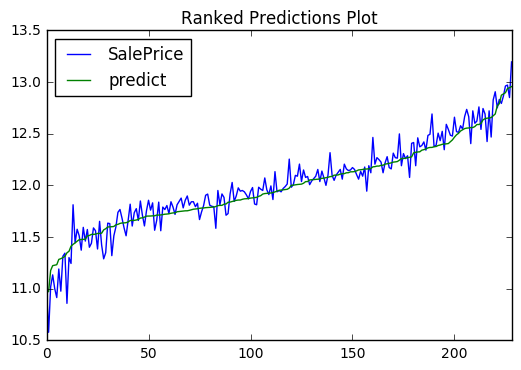

In [25]:
glm_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm_1) # Valid RMSE: ~0.1196, 0.13531 on public leaderboard

#### Blend predictions

In [28]:
# pred_blender('../data/', 
#             ['submission_Thu_May_24_12_46_57_2018.csv',
#              'submission_Thu_May_24_12_52_32_2018.csv'])
# 0.13338 on public leaderboard, better than single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  118403.825877  106536.569642  112470.197759
1  1462  149407.161615  151691.177618  150549.169617
2  1463  174213.108637  171066.095162  172639.601899
3  1464  189052.712822  187183.247949  188117.980385
4  1465  191824.944374  195710.891940  193767.918157


In [29]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)